In [35]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.set_random_seed(0)

In [36]:
import pickle 
f = open('freyfaces.pkl', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
x = u.load()
f.close()

In [37]:
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out)) 
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = low, maxval = high, dtype = tf.float32)

In [38]:
class VAE(object):
    def __init__(self, dim_input, dim_latent, hu_encoder, hu_decoder, batch_size, learning_rate, LB):
        self.dim_input = dim_input
        self.dim_latent = dim_latent
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Input
        self.x = tf.placeholder(tf.float32, [None, dim_input])

        # Encoder
        self.z_mean, self.z_log_sigma_sq = self._encoder(dim_input, dim_latent, hu_encoder)
        
        # Latent Z
        eps = tf.random_normal((batch_size, dim_latent), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.z_mean, tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # Decoder
        self.x_reconstr_mean = self._decoder(dim_input, dim_latent, hu_decoder)
        
        # Optimizer
        self._optimizer(learning_rate, LB)
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
                       
    def _encoder(self, dim_input, dim_latent, n_hidden):
        hidden_w = tf.Variable(xavier_init(dim_input, n_hidden))
        hidden_b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))
        out_mu_w = tf.Variable(xavier_init(n_hidden, dim_latent)) 
        out_mu_b = tf.Variable(tf.zeros([dim_latent], dtype=tf.float32))
        out_sigma_w = tf.Variable(xavier_init(n_hidden, dim_latent)) 
        out_sigma_b = tf.Variable(tf.zeros([dim_latent], dtype=tf.float32))
        
        hidden_layer = tf.nn.softplus(tf.add(tf.matmul(self.x, hidden_w), hidden_b))
        z_mean = tf.add(tf.matmul(hidden_layer, out_mu_w), out_mu_b)
        z_log_sigma_sq = tf.add(tf.matmul(hidden_layer, out_sigma_w), out_sigma_b)
        return z_mean, z_log_sigma_sq

    def _decoder(self, dim_input, dim_latent, n_hidden):
        hidden_w = tf.Variable(xavier_init(dim_latent, n_hidden))
        self.hidden_weights = hidden_w
        hidden_b = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))
        out_w = tf.Variable(xavier_init(n_hidden, dim_input)) 
        out_b = tf.Variable(tf.zeros([dim_input], dtype=tf.float32))
        #out_sigma_w = tf.Variable(xavier_init(n_hidden, dim_input)) 
        #out_sigma_b = tf.Variable(tf.zeros([dim_input], dtype=tf.float32))
        
        hidden_layer = tf.nn.softplus(tf.add(tf.matmul(self.z, hidden_w), hidden_b))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(hidden_layer, out_w), out_b))
        #x_reconstr_log_sigma_sq = tf.add(tf.matmul(hidden_layer, out_sigma_w), out_sigma_b)
        return x_reconstr_mean#, x_reconstr_log_sigma_sq
    
    def _optimizer(self, learning_rate, LB):
        
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        #(-(0.5 * np.log(2 * np.pi) + 0.5 * log_sigma_decoder) -
        #              0.5 * ((x - reconstructed_x)**2 / T.exp(log_sigma_decoder)))
        
        reconstr_loss =  -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        
        #    -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
         #                  + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)

        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                       - tf.square(self.z_mean) 
                                       - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def get_cost(self, X):
        cost = self.sess.run(self.cost, feed_dict={self.x: X})
        return cost
    
    def get_weights(self):
        weights = self.sess.run(self.hidden_weights)
        return weights
    
    def get_cost_la(self, X):
        cost = self.sess.run(self.cost_la, feed_dict={self.x: X})
        return cost
    
    def get_cost_lb(self, X):
        cost = self.sess.run(self.cost_lb, feed_dict={self.x: X})
        return cost
    
    def encode_mean(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def encode_variational(self, X):
        return self.sess.run(self.z, feed_dict={self.x: X})
    
    def generate_prior(self):
        z_mu = np.random.normal(self.dim_latent)
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    
    def generate_z(self, z_mu):
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [39]:
def train_model(data, epoch, latent_dim, hidden_units, batch_size, learning_rate, LB):
    input_dim = data.shape[1]
    n_samples = data.shape[0]
    model = VAE(input_dim, latent_dim, hidden_units, hidden_units, batch_size, learning_rate, LB)
    training_costs = []
    test_costs = []
    for e in range(epoch):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch = data.take(range(i * batch_size, (i+1) * batch_size), mode='wrap', axis = 0)
            #print(batch.shape)

            # Fit training using batch data
            cost = model.partial_fit(batch)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if (e % 20 == 0):
            print("Epoch:", '%04d' % (e+1), "cost=", "{:.9f}".format(avg_cost))

    return model

In [40]:
model = train_model(x, 500, 2, 200, 100, 0.001, True)    

Epoch: 0001 cost= 355.650234077
Epoch: 0021 cost= 342.646895935
Epoch: 0041 cost= 341.296855742
Epoch: 0061 cost= 340.320333622
Epoch: 0081 cost= 340.325671480
Epoch: 0101 cost= 339.994562746
Epoch: 0121 cost= 339.792270806
Epoch: 0141 cost= 339.566369287
Epoch: 0161 cost= 339.439978369
Epoch: 0181 cost= 339.505792283
Epoch: 0201 cost= 339.141010158
Epoch: 0221 cost= 338.945829668
Epoch: 0241 cost= 338.768745403
Epoch: 0261 cost= 338.687755012
Epoch: 0281 cost= 338.647217107
Epoch: 0301 cost= 338.585233033
Epoch: 0321 cost= 338.316130116
Epoch: 0341 cost= 338.454468705
Epoch: 0361 cost= 338.160759147
Epoch: 0381 cost= 338.338254972
Epoch: 0401 cost= 338.374097984
Epoch: 0421 cost= 338.232651727
Epoch: 0441 cost= 338.339137109
Epoch: 0461 cost= 338.282740935
Epoch: 0481 cost= 338.093267931


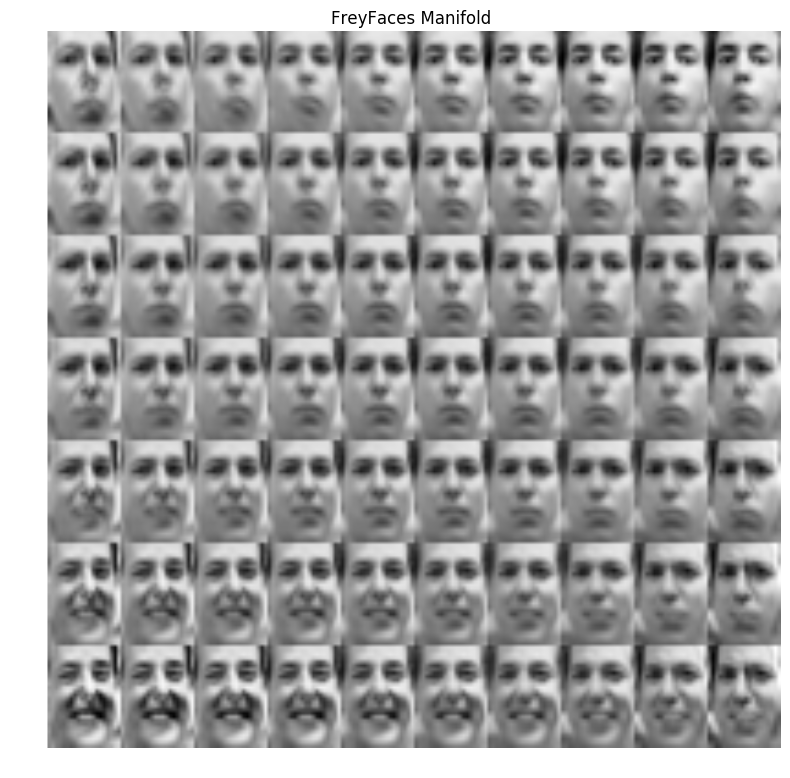

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

nx = 7
ny = 10
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

canvas = np.empty((28*nx, 20*ny))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*model.batch_size)
        x_mean = model.generate_z(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*20:(j+1)*20] = 1 - x_mean[0].reshape(28, 20)

plt.figure(figsize=(8, 10)) 
plt.title('FreyFaces Manifold')
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.xticks(x_values)
plt.tight_layout()
plt.axis('off')
plt.savefig('manifold.pdf')    